In [1]:
import torch 
import os 
import sys
from collections import Counter
from torchvision import datasets, transforms
import copy
from tqdm import tqdm
from urllib import request
import zipfile
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

# Add parent directory to path BEFORE importing from src
sys.path.insert(0, '..')

from torchinfo import summary 
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from src.model_builder import XceptionCustom  
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torch.autograd import Variable
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from sklearn.linear_model import LinearRegression
import lime
from lime import lime_image
from skimage.io import imread
from src.dataloaders import *
from src.utils import *
import warnings
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import Ridge
from pathlib import Path 
# Suppress all warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_distances

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from skimage.measure import regionprops

import torch.nn.functional as F
from sklearn.metrics import pairwise_distances
import networkx as nx
from scipy.stats import multivariate_normal



/home/nlfrx7981/uncertainty/BNN-Uncertainty-Polar-Lows/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_dir = '/home/nlfrx7981/uncertainty/data/polar-lows/test'
train_dir = '/home/nlfrx7981/uncertainty/data/polar-lows/train'

# for local experiments 
# test_dir = '/Users/nicologrometto/Documents/interpretability/data/test'
# train_dir = '/Users/nicologrometto/Documents/interpretability/data/train'

device = get_device('auto')
print(device)

cuda


In [3]:
train_transform, test_transform = get_transforms() 
train_loader, test_loader, n_pos_train, n_neg_train, class_to_idx_dict = create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                train_transform=train_transform,
                                                                                test_transform=test_transform)
print(class_to_idx_dict)

# Load the best model weights
model = XceptionCustom(input_channels=3)
model.load_state_dict(torch.load('../src/outputs/20.08.25_polar_lows_customex.pth'))

# for local experiments
# model.load_state_dict(torch.load('../models_local/trained_base_model.pth'))


# evaluate model 
y_pred_labels_np, y_true_np, y_pred_probs_np, misclassified_images, misclassified_true_labels, misclassified_pred_labels, misclassified_prob_vectors = evaluate_model(model, test_loader, device)

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_true_np, y_pred_labels_np))
print(f"\nFound {len(misclassified_images)} misclassified images.")

Positive training samples: 254 (16%), Negative training samples: 1293 (83%)
{'neg': 0, 'pos': 1}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       371
           1       0.92      0.95      0.94        64

    accuracy                           0.98       435
   macro avg       0.96      0.97      0.96       435
weighted avg       0.98      0.98      0.98       435


Found 8 misclassified images.


In [4]:
print(f'Size of misclassified images: {misclassified_images[0].shape}') 


Size of misclassified images: torch.Size([3, 512, 512])


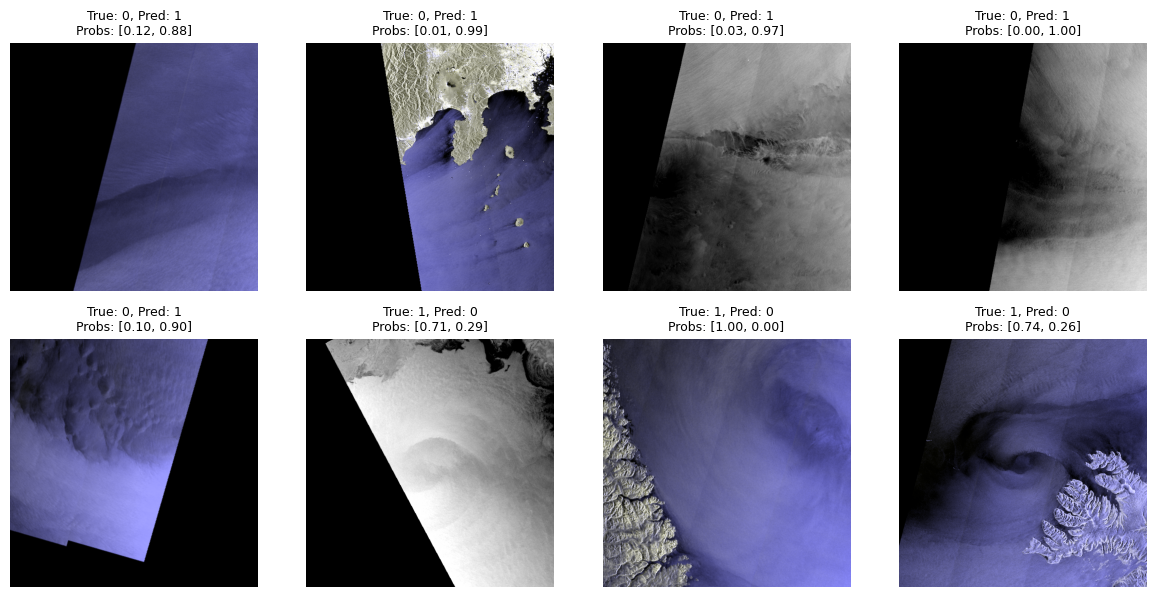

In [5]:
# --- plot misclassified images with probabilities ---
fig, axes = plt.subplots(4, 4, figsize=(12, 12)) # Create a 4x4 grid of subplots
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i in range(len(misclassified_images)):
    ax = axes[i]
    # Convert the image tensor (CHW) to NumPy array (HWC) for matplotlib
    img = misclassified_images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)

    # Format the probability vector for display
    prob_vec = misclassified_prob_vectors[i].numpy()
    # Assuming two classes, e.g., [prob_neg, prob_pos]
    subtitle = f"True: {misclassified_true_labels[i]}, Pred: {misclassified_pred_labels[i]}\nProbs: [{prob_vec[0]:.2f}, {prob_vec[1]:.2f}]"
    ax.set_title(subtitle, fontsize=9) # Adjust fontsize as needed
    ax.axis('off') # Turn off the axes for each subplot

# Hide any unused subplots if fewer than 16 images are displayed
for j in range(len(misclassified_images), 16):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()

Original image size: (800, 800)
Transformed image shape: torch.Size([3, 512, 512])
Transformed image dtype: torch.float32
Transformed image range: [0.000, 1.000]


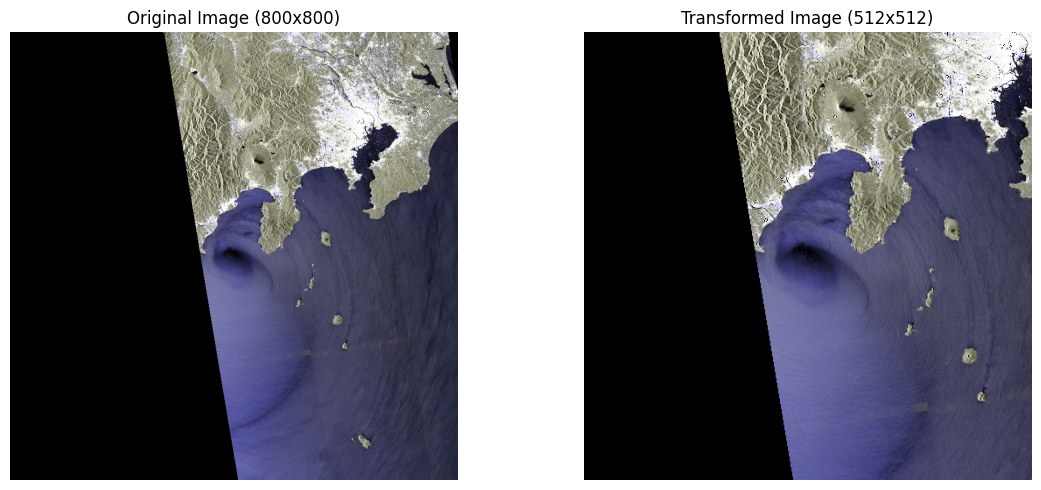

Batched image shape for model input: torch.Size([1, 3, 512, 512])
tensor([[0.0011, 0.9989]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [6]:
# Load sample image
image_path = Path(test_dir)/'pos'/'cffe42_20191012T084028_20191012T084212_mos_rgb.png'
image = get_image(image_path)

print(f"Original image size: {image.size}")

# Get the same transforms used for testing/inference
train_transform, test_transform = get_transforms()

# Apply the test transform (same as used during model evaluation)
transformed_image = test_transform(image)

print(f"Transformed image shape: {transformed_image.shape}")
print(f"Transformed image dtype: {transformed_image.dtype}")
print(f"Transformed image range: [{transformed_image.min():.3f}, {transformed_image.max():.3f}]")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original image
axes[0].imshow(image)
axes[0].set_title(f"Original Image ({image.size[0]}x{image.size[1]})")
axes[0].axis('off')

# Transformed image (convert tensor back to displayable format)
# PyTorch tensors are in CHW format, matplotlib expects HWC
transformed_display = transformed_image.permute(1, 2, 0)  # CHW -> HWC
axes[1].imshow(transformed_display)
axes[1].set_title(f"Transformed Image ({transformed_image.shape[1]}x{transformed_image.shape[2]})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# The transformed_image now ready to be fed to model
# It's a tensor with shape (3, 512, 512) and values in [0, 1]

# for model inference:
batched_image = transformed_image.unsqueeze(0)  # Shape: (1, 3, 512, 512)
print(f"Batched image shape for model input: {batched_image.shape}")

model.eval()
logits_sample_img = model(batched_image.to(device))
print(torch.softmax(logits_sample_img, dim=1)) 

In [163]:
########
### COMPLETE LIME IMPLEMENTATION
########

def prepare_image_for_lime(transformed_image):
    """Convert PyTorch tensor to numpy array format expected by LIME"""
    if isinstance(transformed_image, torch.Tensor):
        # Convert tensor to numpy
        img_np = transformed_image.detach().cpu().numpy()
        # If tensor is in CHW format (channels first), convert to HWC
        if img_np.shape[0] == 3 or img_np.shape[0] == 1:  # Check if channels first
            img_np = np.transpose(img_np, (1, 2, 0))  # CHW -> HWC
        # Ensure values are in [0, 255] range for LIME
        if img_np.max() <= 1.0:  # If normalized to [0,1]
            img_np = (img_np * 255).astype(np.uint8)
        else:
            img_np = img_np.astype(np.uint8)
        return img_np
    return transformed_image


def batch_predict(images, model, device):
    """
    Prediction function for LIME that converts numpy arrays back to tensors
    
    Args:
        images: numpy array of shape (batch_size, height, width, channels)
        model: PyTorch model
        device: PyTorch device
        
    Returns:
        numpy array of predictions
    """
    # Convert numpy array back to tensor format expected by your model
    if isinstance(images, np.ndarray):
        # Convert HWC to CHW format
        if len(images.shape) == 4:  # Batch of images
            images_tensor = torch.from_numpy(images).permute(0, 3, 1, 2).float()
        else:  # Single image
            images_tensor = torch.from_numpy(images).permute(2, 0, 1).float().unsqueeze(0)
        
        # Normalize to [0,1] if needed (if your model expects [0,1] range)
        if images_tensor.max() > 1.0:
            images_tensor = images_tensor / 255.0
            
        # Move to device if needed
        images_tensor = images_tensor.to(device)
    else:
        images_tensor = images

    # Get model predictions
    model.eval()
    with torch.no_grad():
        predictions = torch.softmax(model(images_tensor), dim=1)
    
    # Convert to numpy for LIME
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    
    return predictions


def custom_slic_segmentation(image, n_superpixels, compactness, sigma=1):
    """Custom SLIC segmentation function for LIME"""
    return slic(
        image=image, 
        n_segments=n_superpixels, 
        compactness=compactness,
        start_label=0,
        sigma=sigma, 
        channel_axis=-1
    )


def run_standard_lime(model, transformed_image, device, n_samples, n_superpixels, compactness, top_k=10):
    """
    Run standard LIME explanation with reconciled plotting
    """
    
    # Convert tensor to format expected by LIME
    lime_image_np = prepare_image_for_lime(transformed_image)
    
    # Create prediction function with model and device bound
    def predict_fn(images):
        return batch_predict(images, model, device)
    
    # Create segmentation function with parameters
    def segmentation_fn(image):
        return custom_slic_segmentation(image, n_superpixels, compactness)
    
    # Create LIME explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Generate explanation
    print("Generating LIME explanation...")
    explanation = explainer.explain_instance(
        lime_image_np,
        predict_fn,
        top_labels=2,
        num_samples=n_samples,
        segmentation_fn=segmentation_fn  
    )
    
    # Get segmentation used by LIME for visualization
    segments = segmentation_fn(lime_image_np)
    
    # Extract LIME feature importance scores
    segments_and_scores = explanation.local_exp[explanation.top_labels[0]]
    
    # Create LIME coefficient heatmap
    lime_coeff_map = np.zeros_like(segments, dtype=float)
    for seg_id, score in segments_and_scores:
        mask = (segments == seg_id)
        lime_coeff_map[mask] = score
    
    # Plot results in 6-panel layout for comparison
    plt.figure(figsize=(18, 6))
    
    # Original image
    plt.subplot(1, 6, 1)
    plt.imshow(lime_image_np)
    plt.title('Original Image')
    plt.axis('off')

    # Superpixel segmentation
    plt.subplot(1, 6, 2)
    boundary_img = mark_boundaries(lime_image_np/255.0, segments, color=(1, 1, 0))
    plt.imshow(boundary_img)
    plt.title(f'Superpixels\n({np.max(segments)} segments)')
    plt.axis('off')
    
    # Plot 3: Top segments by ABSOLUTE importance (your current implementation)
    plt.subplot(1, 6, 3)
    top_segments_abs = sorted(segments_and_scores, key=lambda x: abs(x[1]), reverse=True)[:top_k+5]
    important_segments_abs = [seg_id for seg_id, score in top_segments_abs]
    
    masked_segments_abs = np.zeros_like(segments)
    for seg_id in important_segments_abs:
        masked_segments_abs[segments == seg_id] = seg_id
    
    plt.imshow(mark_boundaries(lime_image_np/255.0, masked_segments_abs, color=(1, 1, 0), mode='thick'))
    plt.title(f'Top {top_k} by ABS Importance\n(Pos + Neg effects)')
    plt.axis('off')
    
    # Plot 4: Top segments by POSITIVE importance only (to match Plot 6)
    plt.subplot(1, 6, 4)
    # Filter for positive scores only, then sort by magnitude
    positive_segments = [(seg_id, score) for seg_id, score in segments_and_scores if score > 0]
    top_positive_segments = sorted(positive_segments, key=lambda x: x[1], reverse=True)[:top_k]
    important_positive_segments = [seg_id for seg_id, score in top_positive_segments]
    
    masked_segments_pos = np.zeros_like(segments)
    for seg_id in important_positive_segments:
        masked_segments_pos[segments == seg_id] = seg_id
    
    plt.imshow(mark_boundaries(lime_image_np/255.0, masked_segments_pos, color=(1, 1, 0), mode='thick'))
    plt.title(f'Top {top_k} POSITIVE Only')
    plt.axis('off')

    # Plot 5: LIME coefficient heatmap
    plt.subplot(1, 6, 5)
    im = plt.imshow(lime_coeff_map, cmap='RdBu_r', alpha=0.9)
    plt.title('LIME Feature Importance\n(Red=Pos, Blue=Neg)')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    '''
    # Print detailed comparison for inspection
    print("\n" + "="*30)
    print("LIME EXPLANATION COMPARISON")
    print("="*30)
    
    print(f"\nTop {top_k} segments by ABSOLUTE importance (Plot 3):")
    for i, (seg_id, score) in enumerate(top_segments_abs):
        effect = "POSITIVE" if score > 0 else "NEGATIVE"
        print(f"  {i+1}. Segment {seg_id}: {score:.4f} ({effect})")
    
    print(f"\nTop {top_k} segments by POSITIVE importance (Plot 4):")
    for i, (seg_id, score) in enumerate(top_positive_segments):
        print(f"  {i+1}. Segment {seg_id}: {score:.4f} (POSITIVE)")
    
    
    # Show statistics
    all_scores = [score for _, score in segments_and_scores]
    positive_scores = [score for _, score in segments_and_scores if score > 0]
    negative_scores = [score for _, score in segments_and_scores if score < 0]
    
    print(f"\nScore Statistics:")
    print(f"  Total segments: {len(all_scores)}")
    print(f"  Positive segments: {len(positive_scores)}")
    print(f"  Negative segments: {len(negative_scores)}")
    print(f"  Neutral segments: {len(all_scores) - len(positive_scores) - len(negative_scores)}")
    
    '''
    return explanation, lime_image_np, segments

Generating LIME explanation...


100%|██████████| 1000/1000 [00:10<00:00, 97.19it/s]


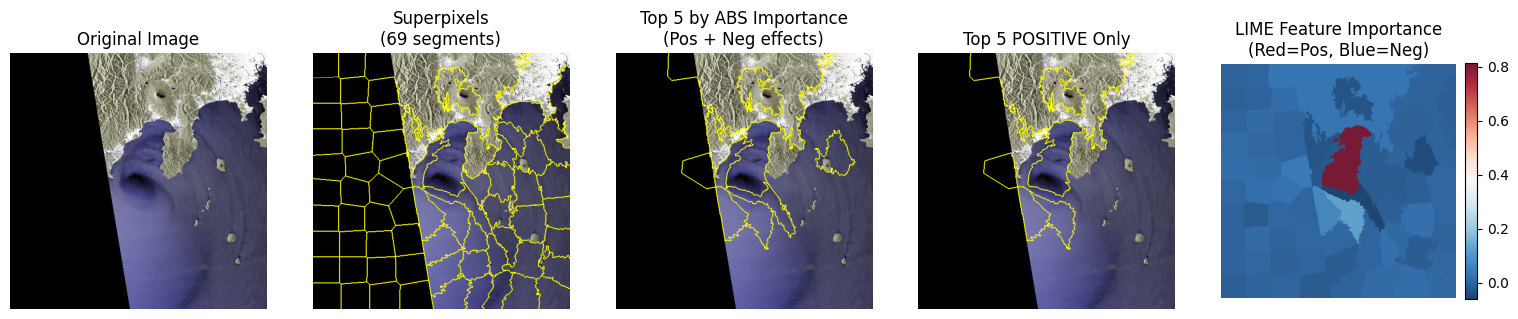

Generating LIME explanation...


100%|██████████| 1000/1000 [00:11<00:00, 87.29it/s]


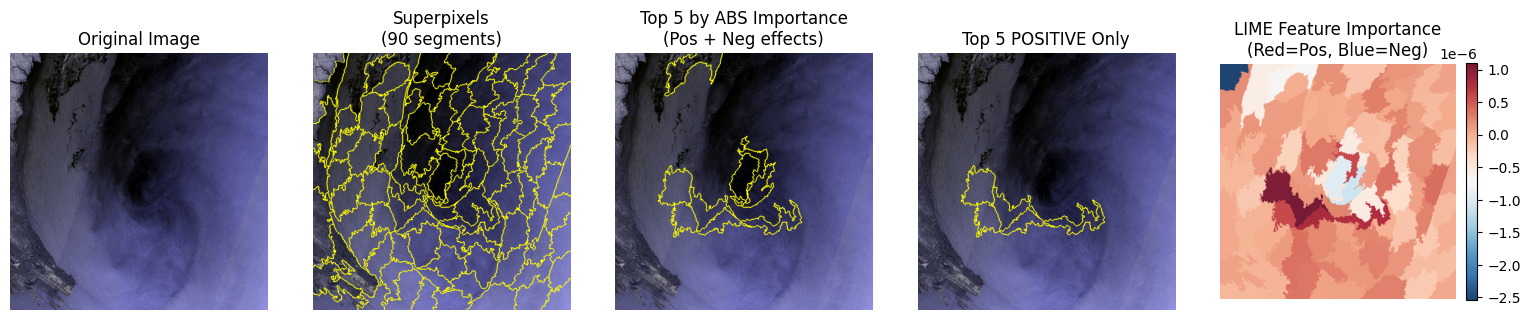

In [164]:
image_path = Path(test_dir)/'pos'/'cffe42_20191012T084028_20191012T084212_mos_rgb.png'
image = get_image(image_path)
transformed_image = test_transform(image)

explanation, lime_image_np, segments = run_standard_lime(
    model, transformed_image, device, 
    n_samples=1000,  # Match simple
    n_superpixels=100, 
    compactness=5,  # Match simple
    top_k=5
)

###

image_path = Path(test_dir)/'pos'/'e8b0d4_20181231T025037_20181231T025219_mos_rgb.png'
image = get_image(image_path)
transformed_image = test_transform(image)

explanation, lime_image_np, segments = run_standard_lime(
    model, transformed_image, device, 
    n_samples=1000,  # Match simple
    n_superpixels=100, 
    compactness=5,  # Match simple
    top_k=5
)


--- Testing with black replacement ---
Original confidence: 0.9989
Baseline (black) confidence: 0.0000


Insertion: 100%|██████████| 20/20 [00:00<00:00, 534.29it/s]


Deletion AUC: 0.0239
Insertion AUC: 0.4730
Final deletion score: 0.0029
Initial insertion score: 0.0000

--- Testing with mean replacement ---
Original confidence: 0.9989
Baseline (mean) confidence: 0.0000


Insertion: 100%|██████████| 20/20 [00:00<00:00, 515.91it/s]


Deletion AUC: 0.0589
Insertion AUC: 0.4691
Final deletion score: 0.5725
Initial insertion score: 0.0000

--- Testing with noise replacement ---
Original confidence: 0.9989
Baseline (noise) confidence: 0.0000


Insertion: 100%|██████████| 20/20 [00:00<00:00, 457.26it/s]


Deletion AUC: 0.0528
Insertion AUC: 0.7120
Final deletion score: 0.0055
Initial insertion score: 0.0000


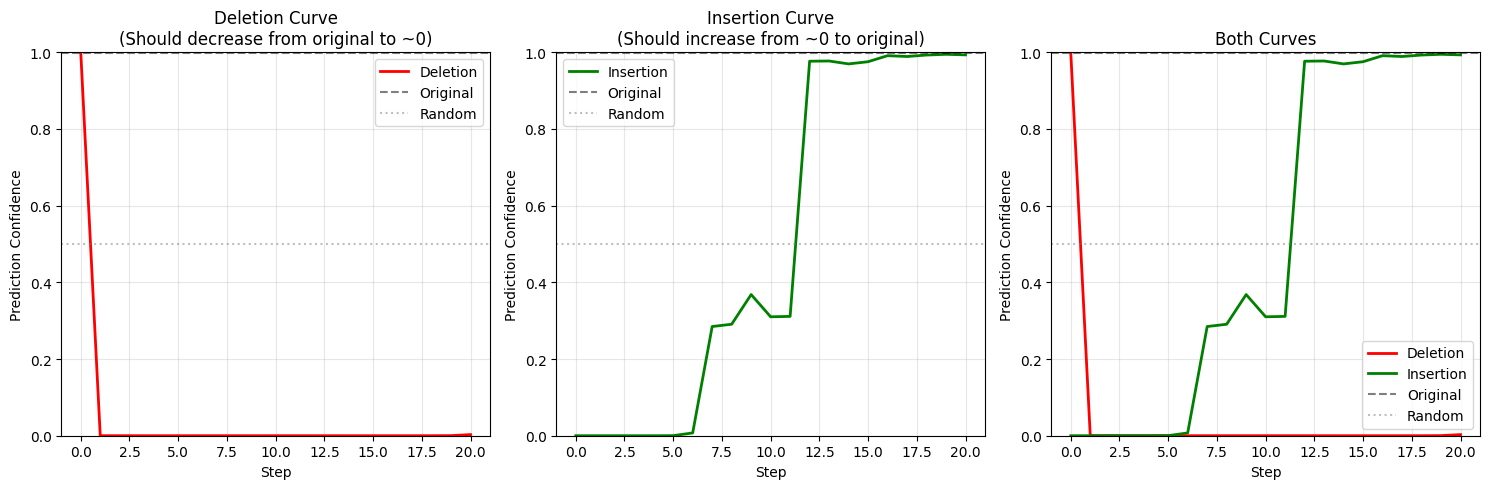

In [56]:
def deletion_metric(model, image, explanation, device, steps=50, replacement_strategy='black'):
    """
    Deletion metric: Remove most important features progressively
    
    Args:
        model: PyTorch model
        image: Original image (tensor or numpy array)
        explanation: LIME explanation object
        device: PyTorch device
        steps: Number of deletion steps
        replacement_strategy: 'black', 'mean', or 'noise'
    """
    # Get the segmentation
    segments = explanation.segments
    
    # Get importance scores - correct LIME attribute access
    top_label = explanation.top_labels[0] # Get the top predicted label
    local_exp = explanation.local_exp[top_label] # This gives list of (segment_id, importance)
    segment_importance = dict(local_exp)
    
    # Get all unique segments and their importance scores
    all_segments = np.unique(segments)
    importance_scores = []
    for seg in all_segments:
        importance_scores.append(segment_importance.get(seg, 0))
    
    # Sort segments by importance (descending - most important first)
    sorted_indices = np.argsort(np.abs(importance_scores))[::-1]
    sorted_segments = all_segments[sorted_indices]
    
    # Prepare image
    if isinstance(image, torch.Tensor):
        original_image = image.clone()
    else:
        original_image = torch.from_numpy(image).permute(2, 0, 1).float()
    
    if original_image.max() > 1.0:
        original_image = original_image / 255.0
    
    original_image = original_image.to(device)
    
    # Get original prediction
    model.eval()
    with torch.no_grad():
        original_pred = torch.softmax(model(original_image.unsqueeze(0)), dim=1)
        original_class = torch.argmax(original_pred, dim=1).item()
        original_prob = original_pred[0, original_class].item()
    
    deletion_scores = [original_prob]
    current_image = original_image.clone()
    
    # Prepare replacement values based on strategy
    if replacement_strategy == 'mean':
        # Use dataset mean (ImageNet standard: [0.485, 0.456, 0.406])
        replacement_values = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    elif replacement_strategy == 'noise':
        # Will generate noise per step
        replacement_values = None
    else:  # 'black' or default
        replacement_values = torch.zeros(3, 1, 1).to(device)
    
    # Progressive deletion
    segments_per_step = max(1, len(sorted_segments) // steps)
    
    for step in tqdm(range(steps), desc="Deletion"):
        start_idx = step * segments_per_step
        end_idx = min((step + 1) * segments_per_step, len(sorted_segments))
        
        if start_idx >= len(sorted_segments):
            # All segments removed, should be close to 0
            deletion_scores.append(deletion_scores[-1])
            continue
        
        # Remove segments for this step
        for i in range(start_idx, end_idx):
            if i < len(sorted_segments):
                seg_id = sorted_segments[i]
                mask = (segments == seg_id)
                mask_tensor = torch.from_numpy(mask).to(device)
                
                # Apply replacement strategy
                if replacement_strategy == 'noise':
                    # Generate random noise with same statistics as original
                    noise = torch.randn_like(current_image[:, mask_tensor]) * 0.1 + 0.5
                    current_image[:, mask_tensor] = torch.clamp(noise, 0, 1)
                else:
                    # Use replacement values (black or mean)
                    for c in range(current_image.shape[0]):
                        current_image[c, mask_tensor] = replacement_values[c, 0, 0]
        
        # Get prediction for modified image
        with torch.no_grad():
            pred = torch.softmax(model(current_image.unsqueeze(0)), dim=1)
            prob = pred[0, original_class].item()
            deletion_scores.append(prob)
    
    # Calculate AUC (Area Under Curve)
    deletion_auc = np.trapezoid(deletion_scores) / len(deletion_scores)
    
    return deletion_auc, deletion_scores


def insertion_metric(model, image, explanation, device, steps=50, replacement_strategy='black'):
    """
    Insertion metric: Start with completely modified image and add back most important features
    """
    # Get the segmentation
    segments = explanation.segments
    
    # Get importance scores
    top_label = explanation.top_labels[0]
    local_exp = explanation.local_exp[top_label]
    segment_importance = dict(local_exp)
    
    # Get all unique segments and their importance scores
    all_segments = np.unique(segments)
    importance_scores = []
    for seg in all_segments:
        importance_scores.append(segment_importance.get(seg, 0))
    
    # Sort segments by importance (descending - most important first)
    sorted_indices = np.argsort(np.abs(importance_scores))[::-1]
    sorted_segments = all_segments[sorted_indices]
    
    # Prepare image
    if isinstance(image, torch.Tensor):
        original_image = image.clone()
    else:
        original_image = torch.from_numpy(image).permute(2, 0, 1).float()
    
    if original_image.max() > 1.0:
        original_image = original_image / 255.0
    
    original_image = original_image.to(device)
    
    # Get original prediction for reference
    model.eval()
    with torch.no_grad():
        original_pred = torch.softmax(model(original_image.unsqueeze(0)), dim=1)
        original_class = torch.argmax(original_pred, dim=1).item()
    
    # Start with completely modified image (all segments replaced)
    if replacement_strategy == 'mean':
        # Use ImageNet mean
        current_image = torch.full_like(original_image, 0)
        current_image[0] = 0.485  # R channel
        current_image[1] = 0.456  # G channel  
        current_image[2] = 0.406  # B channel
    elif replacement_strategy == 'noise':
        # Random noise
        current_image = torch.clamp(torch.randn_like(original_image) * 0.1 + 0.5, 0, 1)
    else:  # 'black' or default
        current_image = torch.zeros_like(original_image)
    
    # Get initial prediction (should be very low)
    with torch.no_grad():
        initial_pred = torch.softmax(model(current_image.unsqueeze(0)), dim=1)
        initial_prob = initial_pred[0, original_class].item()
    
    insertion_scores = [initial_prob]
    
    # Progressive insertion (restoration)
    segments_per_step = max(1, len(sorted_segments) // steps)
    
    for step in tqdm(range(steps), desc="Insertion"):
        start_idx = step * segments_per_step
        end_idx = min((step + 1) * segments_per_step, len(sorted_segments))
        
        if start_idx >= len(sorted_segments):
            # All segments restored
            insertion_scores.append(insertion_scores[-1])
            continue
        
        # Restore (insert) segments for this step
        for i in range(start_idx, end_idx):
            if i < len(sorted_segments):
                seg_id = sorted_segments[i]
                mask = (segments == seg_id)
                mask_tensor = torch.from_numpy(mask).to(device)
                
                # Restore original pixels
                current_image[:, mask_tensor] = original_image[:, mask_tensor]
        
        # Get prediction for modified image
        with torch.no_grad():
            pred = torch.softmax(model(current_image.unsqueeze(0)), dim=1)
            prob = pred[0, original_class].item()
            insertion_scores.append(prob)
    
    # Calculate AUC
    insertion_auc = np.trapezoid(insertion_scores) / len(insertion_scores)
    
    return insertion_auc, insertion_scores


def plot_deletion_insertion_curves(deletion_scores, insertion_scores, original_prob):
    """Plot deletion and insertion curves with proper scaling"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(deletion_scores, 'r-', linewidth=2, label='Deletion')
    plt.axhline(y=original_prob, color='k', linestyle='--', alpha=0.5, label='Original')
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Random')
    plt.xlabel('Step')
    plt.ylabel('Prediction Confidence')
    plt.title('Deletion Curve\n(Should decrease from original to ~0)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, 1)
    
    plt.subplot(1, 3, 2)
    plt.plot(insertion_scores, 'g-', linewidth=2, label='Insertion')
    plt.axhline(y=original_prob, color='k', linestyle='--', alpha=0.5, label='Original')
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Random')
    plt.xlabel('Step')
    plt.ylabel('Prediction Confidence')
    plt.title('Insertion Curve\n(Should increase from ~0 to original)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, 1)
    
    plt.subplot(1, 3, 3)
    plt.plot(deletion_scores, 'r-', linewidth=2, label='Deletion')
    plt.plot(insertion_scores, 'g-', linewidth=2, label='Insertion')
    plt.axhline(y=original_prob, color='k', linestyle='--', alpha=0.5, label='Original')
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Random')
    plt.xlabel('Step')
    plt.ylabel('Prediction Confidence')
    plt.title('Both Curves')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()


# Test with different replacement strategies
def run_comprehensive_evaluation(model, image, explanation, device):
    """Run evaluation with different replacement strategies"""
    
    # Get original prediction for reference
    if isinstance(image, torch.Tensor):
        test_image = image.clone()
    else:
        test_image = torch.from_numpy(image).permute(2, 0, 1).float()
    
    if test_image.max() > 1.0:
        test_image = test_image / 255.0
    
    test_image = test_image.to(device)
    
    model.eval()
    with torch.no_grad():
        original_pred = torch.softmax(model(test_image.unsqueeze(0)), dim=1)
        original_prob = torch.max(original_pred).item()
    
    strategies = ['black', 'mean', 'noise']
    results = {}
    
    for strategy in strategies:
        print(f"\n--- Testing with {strategy} replacement ---")
        
        # Test baseline (fully modified image)
        if strategy == 'black':
            baseline_image = torch.zeros_like(test_image)
        elif strategy == 'mean':
            baseline_image = torch.full_like(test_image, 0)
            baseline_image[0] = 0.485
            baseline_image[1] = 0.456  
            baseline_image[2] = 0.406
        else:  # noise
            baseline_image = torch.clamp(torch.randn_like(test_image) * 0.1 + 0.5, 0, 1)
        
        with torch.no_grad():
            baseline_pred = torch.softmax(model(baseline_image.unsqueeze(0)), dim=1)
            baseline_prob = baseline_pred[0, torch.argmax(original_pred)].item()
        
        print(f"Original confidence: {original_prob:.4f}")
        print(f"Baseline ({strategy}) confidence: {baseline_prob:.4f}")
        
        # Run metrics
        deletion_auc, deletion_scores = deletion_metric(
            model, image, explanation, device, steps=20, replacement_strategy=strategy
        )
        
        insertion_auc, insertion_scores = insertion_metric(
            model, image, explanation, device, steps=20, replacement_strategy=strategy
        )
        
        results[strategy] = {
            'deletion_auc': deletion_auc,
            'insertion_auc': insertion_auc,
            'deletion_scores': deletion_scores,
            'insertion_scores': insertion_scores,
            'original_prob': original_prob,
            'baseline_prob': baseline_prob
        }
        
        print(f"Deletion AUC: {deletion_auc:.4f}")
        print(f"Insertion AUC: {insertion_auc:.4f}")
        print(f"Final deletion score: {deletion_scores[-1]:.4f}")
        print(f"Initial insertion score: {insertion_scores[0]:.4f}")
    
    return results

# Run the comprehensive evaluation
results = run_comprehensive_evaluation(model, lime_image_np, explanation, device)

# Plot results for the best strategy (usually 'black' works well)
best_strategy = 'black'  # or choose based on results
plot_deletion_insertion_curves(
    results[best_strategy]['deletion_scores'], 
    results[best_strategy]['insertion_scores'],
    results[best_strategy]['original_prob']
)

# Continuous LIME

Overall, seems less sensitive to randomness in the pertrbations, but more sensitive to segmentation into superpixels.
In addition, it seems to be less sensitive to the bandwidth parameter in weighted regression (with different choice of weights). This points to the idea of dropping the weights entirely, eliminating the need to choose a bandwidth parameter. 
The main idea is eliminate the need to downweight 'more extreme' perturbed samples of the original image as smoother sampling guarantees higher faithfullness and an implicit neighborhood encoding. 
More experiments are needed with Gaussian reweighting, instead of uniform. Is there a need for rescaling?

In [ ]:
def custom_slic_segmentation(image, n_superpixels=200, compactness=10, start_label=1, sigma=1):
    return slic(image, n_superpixels=n_superpixels, compactness=compactness, 
                sigma=sigma, start_label=start_label) 


def uniform_blurred_sampling(image, num_samples):
    """
    More efficient vectorized version.
    """
    # Generate superpixels
    segments = custom_slic_segmentation(image)
    unique_segments = np.unique(segments)
    
    # Generate all weights
    interp_features = np.random.uniform(0, 1, size=(num_samples, len(unique_segments)))
    
    # Convert image to float
    base_image = image.copy().astype(np.float32)
    
    # Create a mapping from segment IDs to indices for vectorization
    # This handles non-consecutive segment IDs
    seg_to_idx = {seg_id: idx for idx, seg_id in enumerate(unique_segments)}
    
    # Create index map for vectorized operations
    segment_indices = np.zeros_like(segments)
    for seg_id, idx in seg_to_idx.items():
        segment_indices[segments == seg_id] = idx
    
    samples = []
    for sample_idx in range(num_samples):
        # Create weight map for this sample
        weight_map = interp_features[sample_idx][segment_indices]
        
        # Apply weights (broadcast across color channels if needed)
        if len(base_image.shape) == 3:
            weight_map = weight_map[:, :, np.newaxis]
        
        blurred_image = base_image * weight_map
        
        # Normalize if needed
        if image.dtype == np.uint8:
            samples.append(blurred_image / 255.0)
        else:
            samples.append(blurred_image)
    
    return samples, segments, interp_features


def explain_image(image, n_samples=1000):
    """
    Generate explanation for an image using spatial coherence sampling
    """
    blurred_samples, _, interp_features = uniform_blurred_sampling(lime_image_np, n_samples)
    
    # Create perturbed images and get predictions
    predictions = []
    model.eval()
    
    for sample in tqdm(blurred_samples):
        
        # Convert perturbed image to tensor, permute to (C, H, W), add batch dim, move to device
        input_tensor = torch.from_numpy(sample).permute(2, 0, 1).unsqueeze(0).float().to(device)
        
        # Get model prediction
        with torch.inference_mode():
            logits = model(input_tensor)
            probs = torch.softmax(logits, dim=1)
            pred = probs.cpu().numpy()[0]
            predictions.append(pred)
    
    predictions = np.array(predictions)
    
    # Get prediction for original image
    input_orig = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
    with torch.inference_mode():
        orig_logits = model(input_orig)
        orig_probs = torch.softmax(orig_logits, dim=1).cpu().numpy()[0]
    
    target_class = np.argmax(orig_probs)
    y = predictions[:, target_class]
    
    ridge = Ridge(alpha=0.01) # practically irrelevant

    # uniform distance 
    #perturbation_distance = np.mean(np.abs(1 - interp_features), axis=1)
    #sample_weights = np.exp(-perturbation_distance / 2)

    # cosine dist weights 
    original_weights = np.ones(interp_features.shape[1])
    cosine_dist = cosine_distances(interp_features, original_weights.reshape(1, -1)).flatten()
    sample_weights = np.exp(-cosine_dist / 0.01)  


    ridge.fit(interp_features, y, sample_weight=sample_weights)
    #ridge.fit(interp_features, y)
    
    return ridge.coef_


def plot_top_k_segments_with_boundaries(img, segments_slic, beta, k=5, boundary_color=(1, 1, 0)):
    """
    Plot the original image with yellow boundaries around the union of the top-k most important superpixels.

    Args:
        img (np.ndarray): Original image, shape (H, W, C).
        segments_slic (np.ndarray): Superpixel labels, shape (H, W).
        beta (np.ndarray): Importance coefficients for each superpixel.
        k (int): Number of top superpixels to highlight.
        boundary_color (tuple): RGB color for the superpixel boundaries.
    """
    # Get top-k superpixel indices
    top_k_indices = np.argsort(beta)[-k:]

    # Create a mask to keep only top-k segments
    mask = np.isin(segments_slic, top_k_indices)

    # Create a new segment map where non-top-k segments are assigned a dummy label (-1)
    # and all top-k segments are merged into a single label (e.g., 0)
    masked_segments = np.full_like(segments_slic, fill_value=-1)
    masked_segments[mask] = 0  # merge all selected superpixels into one segment

    # Plot with yellow boundaries
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(mark_boundaries(img, masked_segments, color=boundary_color, mode='thick'))
    ax.set_title(f"Top-{k} Superpixels (Merged with Yellow Boundaries)")
    ax.axis('off')
    plt.show()


## ignore below
'''
def uniform_blurred_samples(image, num_samples, n_superpixels=100, compactness=10, sigma=1, start_label=1):
    """
    Generate multiple samples of uniformly blurred images using superpixels.
    """
    
    # Generate superpixels once 
    segments = slic(image, n_superpixels, compactness)
    unique_segments = np.unique(segments)
    
    # Generate ALL weights at once - shape (num_samples, n_superpixels)
    interp_features = np.random.uniform(0, 1, size=(num_samples, len(unique_segments)))
    
    # Convert image to float once
    base_image = image.copy().astype(np.float32)
    
    samples = []
    
    for sample_idx in range(num_samples):
        # Start with a fresh copy of the base image for each sample
        blurred_image = base_image.copy()
        
        # Apply the weights for THIS sample
        for i, segment_id in enumerate(unique_segments):
            mask = segments == segment_id
            blurred_image[mask] = blurred_image[mask] * interp_features[sample_idx, i]
        
        # Handle normalization 
        if image.dtype == np.uint8:
            samples.append(blurred_image / 255.0)  # Normalize uint8 images
        else:
            samples.append(blurred_image)  # Keep original scale for float images
    
    return samples, segments  # Return segments for potential reuse
'''
    
#blurred_samples, segments, interp_features = uniform_blurred_samples_vectorized(lime_image_np, 100)

'\ndef uniform_blurred_samples(image, num_samples, n_segments=100, compactness=10, sigma=1, start_label=1):\n    """\n    Generate multiple samples of uniformly blurred images using superpixels.\n    """\n\n    # Generate superpixels once \n    segments = slic(image, n_segments, compactness)\n    unique_segments = np.unique(segments)\n\n    # Generate ALL weights at once - shape (num_samples, n_superpixels)\n    uniform_weights = np.random.uniform(0, 1, size=(num_samples, len(unique_segments)))\n\n    # Convert image to float once\n    base_image = image.copy().astype(np.float32)\n\n    samples = []\n\n    for sample_idx in range(num_samples):\n        # Start with a fresh copy of the base image for each sample\n        blurred_image = base_image.copy()\n\n        # Apply the weights for THIS sample\n        for i, segment_id in enumerate(unique_segments):\n            mask = segments == segment_id\n            blurred_image[mask] = blurred_image[mask] * uniform_weights[sample_idx, i]\

100%|██████████| 10000/10000 [00:12<00:00, 770.93it/s]


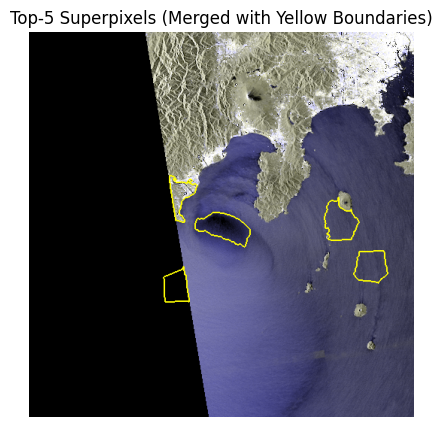

In [57]:
explanation = explain_image(lime_image_np, n_samples=10000)
plot_top_k_segments_with_boundaries(lime_image_np, segments, explanation, k=5, boundary_color=(1, 1, 0))

# Bayes LIME

In [139]:
class BayesLIME: 
    def __init__(self, model, image):
        self.model = model 
        self.image = image
        self.device = next(model.parameters()).device


    def custom_slic_segmentation(self, image, n_superpixels, compactness, sigma=1):
        """Custom SLIC segmentation function for LIME"""
        return slic(
            image=image, 
            n_segments=n_superpixels, 
            compactness=compactness,
            start_label=0,
            sigma=sigma, 
            channel_axis=-1
    )
    
    def get_superpixel_centers(self, superpixels):
        """Get centroid coordinates for each superpixel"""
        props = regionprops(superpixels + 1)  # regionprops expects 1-indexed labels
        centers = np.array([[prop.centroid[0], prop.centroid[1]] for prop in props])
        return centers

    
    def plot_image_boundaries_centers(self, image, superpixels, centers):
        plt.figure(figsize=(3, 3))
        plt.imshow(mark_boundaries(image, superpixels))

        # Unpack the centers into x and y for plotting
        y_coords, x_coords = zip(*centers)

        plt.scatter(x_coords, y_coords, c='red', s=30, marker='x')  # Plot centers
        plt.title('Superpixels with Centers')
        plt.show()


    
    def build_superpixel_graph(self, superpixels):
        """
        Build adjacency graph where superpixels are connected if they share a boundary
        Returns:
            adjacency_matrix: matrix (n_superpixels, n_superpixels) WITHOUT self-loops
            degree_matrix: diagonal matrix with degrees
        """
        n_superpixels = superpixels.max() + 1
        h, w = superpixels.shape
        
        # Find adjacent superpixels by checking 4-connectivity
        adjacencies = set()
        
        # Check horizontal adjacencies
        for i in range(h):
            for j in range(w - 1):
                if superpixels[i, j] != superpixels[i, j + 1]:
                    sp1, sp2 = superpixels[i, j], superpixels[i, j + 1]
                    adjacencies.add((min(sp1, sp2), max(sp1, sp2)))
        
        # Check vertical adjacencies
        for i in range(h - 1):
            for j in range(w):
                if superpixels[i, j] != superpixels[i + 1, j]:
                    sp1, sp2 = superpixels[i, j], superpixels[i + 1, j]
                    adjacencies.add((min(sp1, sp2), max(sp1, sp2)))
        
        # Build adjacency matrix without self-loops
        row_indices = []
        col_indices = []
        
        for sp1, sp2 in adjacencies:
            row_indices.extend([sp1, sp2])
            col_indices.extend([sp2, sp1])
            
        data = np.ones(len(row_indices))
        adjacency_matrix = csr_matrix((data, (row_indices, col_indices)),
                                    shape=(n_superpixels, n_superpixels)).toarray()
        
        # Calculate degrees (sum of each row - no self-loops to remove)
        degrees = np.array(adjacency_matrix.sum(axis=1)).flatten()
        degree_matrix = np.diag(degrees)
        
        return adjacency_matrix, degree_matrix
            

    def visualize_superpixel_graph(self, superpixels, centers, adjacency_matrix):
        """Visualize the superpixel adjacency graph as a network"""
        
        # Convert sparse matrix to NetworkX graph
        G = nx.from_numpy_array(adjacency_matrix)
        
        # Remove self-loops for visualization
        G.remove_edges_from(nx.selfloop_edges(G))
        
        plt.figure(figsize=(10, 4))
        
        # Plot 1: Original image with superpixels
        plt.subplot(1, 2, 1)
        plt.imshow(mark_boundaries(self.image, superpixels))
        y_coords, x_coords = zip(*centers)
        plt.scatter(x_coords, y_coords, c='red', s=30, marker='o')
        plt.title('Superpixels')
        plt.axis('off')
        
        # Plot 2: Graph structure
        plt.subplot(1, 2, 2)
        pos = {i: (centers[i][1], -centers[i][0]) for i in range(len(centers))}  # Note: flip y for plotting
        nx.draw(G, pos, node_size=100, node_color='lightblue', 
                edge_color='gray', alpha=0.7, with_labels=True, font_size=8)
        plt.title('Superpixel Adjacency Graph')
        plt.axis('equal')
        
        plt.tight_layout()
        plt.show()


    def build_prior(self, adjacency_matrix, degree_matrix, method, eps=0.1):
        '''Return mean zero and precision matrix for GMRF'''
        n_superpixels = adjacency_matrix.shape[0]
        
        if method=='graph':
            # Graph Laplacian
            laplacian = degree_matrix - adjacency_matrix
            # Add regularization
            precision_matrix = laplacian + eps * np.eye(n_superpixels)
            return np.zeros(n_superpixels), precision_matrix
        
        elif method=='gauss':
            precision_matrix = np.identity(n_superpixels)
            return np.zeros(n_superpixels), precision_matrix 

    
    def plot_superpixel_heatmap_prior_posterior(self, superpixels, prior_mean, prior_precision, posterior_mean, posterior_precision):
        """
        Plot coefficient values mapped onto superpixels
        
        Args:
            superpixels: (H, W) array with superpixel labels
            prior_mean: 
            prior_precision:
            posterior_mean:
            posterior_precision: 
        """

        n_superpixels = len(np.unique(superpixels))
        prior_draw = multivariate_normal.rvs(prior_mean, np.linalg.inv(prior_precision), size=1)
        # Create coefficient maps
        coeff_map_prior = np.zeros_like(superpixels, dtype=float)
        for sp_id in range(n_superpixels):
            mask = (superpixels == sp_id)
            coeff_map_prior[mask] = prior_draw[sp_id]

        coeff_map_posterior_mean = np.zeros_like(superpixels, dtype=float)
        for sp_id in range(n_superpixels):
            mask = (superpixels == sp_id)
            coeff_map_posterior_mean[mask] = posterior_mean[sp_id]

        coeff_map_posterior_variance = np.zeros_like(superpixels, dtype=float)
        for sp_id in range(n_superpixels):
            mask = (superpixels == sp_id)
            coeff_map_posterior_variance[mask] = np.diag(np.linalg.inv(posterior_precision))[sp_id]
        
        plt.figure(figsize=(15, 15))
        
        # Original image
        plt.subplot(1, 4, 1)
        plt.imshow(self.image)
        plt.title('Original Image')
        plt.axis('off')
        
        # Coefficient heatmap prior
        plt.subplot(1, 4, 2)
        im = plt.imshow(coeff_map_prior, cmap='RdBu_r', alpha=0.9)
        plt.title('Prior draw')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.axis('off')

        # Coefficient heatmap posterior
        plt.subplot(1, 4, 3)
        im = plt.imshow(coeff_map_posterior_mean, cmap='RdBu_r', alpha=0.9)
        plt.title('Posterior mean')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.axis('off')

         # Coefficient heatmap variance
        plt.subplot(1, 4, 4)
        im = plt.imshow(coeff_map_posterior_variance, cmap='RdBu_r', alpha=0.9)
        plt.title('Posterior variance')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()



    def uniform_blurred_sampling(self, image, superpixels, n_samples):
        """
        More efficient vectorized version.
        """
        unique_superpixels = np.unique(superpixels)
        
        # Generate all weights
        interp_features = np.random.uniform(0, 1, size=(n_samples, len(unique_superpixels)))
        
        # Convert image to float
        base_image = image.copy().astype(np.float32)
        
        # Create a mapping from segment IDs to indices for vectorization
        # This handles non-consecutive segment IDs
        seg_to_idx = {seg_id: idx for idx, seg_id in enumerate(unique_superpixels)}
        
        # Create index map for vectorized operations
        segment_indices = np.zeros_like(superpixels)
        for seg_id, idx in seg_to_idx.items():
            segment_indices[superpixels == seg_id] = idx
        
        samples = []
        for sample_idx in range(n_samples):
            # Create weight map for this sample
            weight_map = interp_features[sample_idx][segment_indices]
            
            # Apply weights (broadcast across color channels if needed)
            if len(base_image.shape) == 3:
                weight_map = weight_map[:, :, np.newaxis]
            
            blurred_image = base_image * weight_map
            
            # Normalize if needed
            if image.dtype == np.uint8:
                samples.append(blurred_image / 255.0)
            else:
                samples.append(blurred_image)
        
        return samples, interp_features
    

    def spatial_sampling(self, image, superpixels, n_samples):
        """
        Vectorized distance-weighted spatial sampling
        
        For each sample:
        1. Pick a random "focus" superpixel
        2. Set sampling probability for each superpixel based on distance to focus
        3. Sample independently with these probabilities
        """
        n_superpixels = superpixels.max() + 1
        centers = self.get_superpixel_centers(superpixels)
        
        # Pre-compute distance matrix (n_superpixels x n_superpixels)
        distance_matrix = np.linalg.norm(
            centers[:, np.newaxis, :] - centers[np.newaxis, :, :], 
            axis=2
        )
        
        # Generate random focus points for all samples
        focus_indices = np.random.choice(n_superpixels, size=n_samples)
        
        # Get distances from each focus to all superpixels
        distances_from_foci = distance_matrix[focus_indices]  # Shape: (n_samples, n_superpixels)
        
        # Convert to probabilities vectorized
        max_distances = np.max(distances_from_foci, axis=1, keepdims=True)
        probabilities = 0.05 + 0.9 * np.exp(-distances_from_foci / max_distances)
        
        # Sample all features at once
        random_vals = np.random.random((n_samples, n_superpixels))
        interp_features = (random_vals < probabilities).astype(float)
        
        # Generate samples more efficiently
        samples = []
        base_image = image.copy().astype(np.float32)
        
        # Pre-compute superpixel masks
        masks = {}
        for sp_id in range(n_superpixels):
            masks[sp_id] = (superpixels == sp_id)
        
        for sample_idx in range(n_samples):
            sample_image = base_image.copy()
            feature = interp_features[sample_idx]
            
            # Zero out unsampled superpixels
            for sp_id in range(n_superpixels):
                if feature[sp_id] == 0:
                    sample_image[masks[sp_id]] = 0
                    
            if image.dtype == np.uint8:
                samples.append(sample_image / 255.0)
            else:
                samples.append(sample_image)
        
        return samples, interp_features

    

    
    def model_predictions_perturbations(self, image, superpixels, method, n_samples):
        """
        Generate model predictions on perturbations and extract probabilities for target class
        
        Args:
            image: original image array
            superpixels: superpixel segmentation 
            n_samples: number of perturbation samples
        
        Returns:
            y: target class probabilities for perturbed samples
            interp_features: perturbation weights for each sample
            target_class: the predicted class for original image
        """
        if method=='blurred':
            # Generate samples and weights
            samples, interp_features = self.uniform_blurred_sampling(image, superpixels, n_samples)

        elif method=='spatial':
            samples, interp_features = self.spatial_sampling(image, superpixels, n_samples)
        
        # Create perturbed images and get predictions
        predictions = []
        self.model.eval()  # Use self.model
        
        for sample in tqdm(samples):
            # Convert perturbed image to tensor, permute to (C, H, W), add batch dim, move to device
            input_tensor = torch.from_numpy(sample).permute(2, 0, 1).unsqueeze(0).float().to(self.device)
            
            # Get model prediction
            with torch.inference_mode():
                logits = self.model(input_tensor)  # Use self.model
                probs = torch.softmax(logits, dim=1)
                pred = probs.cpu().numpy()[0]
                predictions.append(pred)
        
        predictions = np.array(predictions)
        
        # Get prediction for original image
        input_orig = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(self.device)
        with torch.inference_mode():
            orig_logits = self.model(input_orig)  # Use self.model
            orig_probs = torch.softmax(orig_logits, dim=1).cpu().numpy()[0]
        
        target_class = np.argmax(orig_probs)
        y = predictions[:, target_class]  # Extract target class probabilities
        
        return y, interp_features, target_class



    def build_MGRF_posterior(self, prior_precision, interp_features, y, sigma=0.1):   # simplest case with iid error terms - larger sigma leads to higher uncertainty in explanations - this has to be tuned - what does it mean for sigma to be larger than 1??
        posterior_precision = prior_precision + sigma**(-2)*np.dot(interp_features.T, interp_features)
        posterior_mean = np.dot(np.linalg.inv(posterior_precision), sigma**(-2)*np.dot(interp_features.T, y))
        return posterior_mean, posterior_precision

LIME image size: (512, 512, 3)


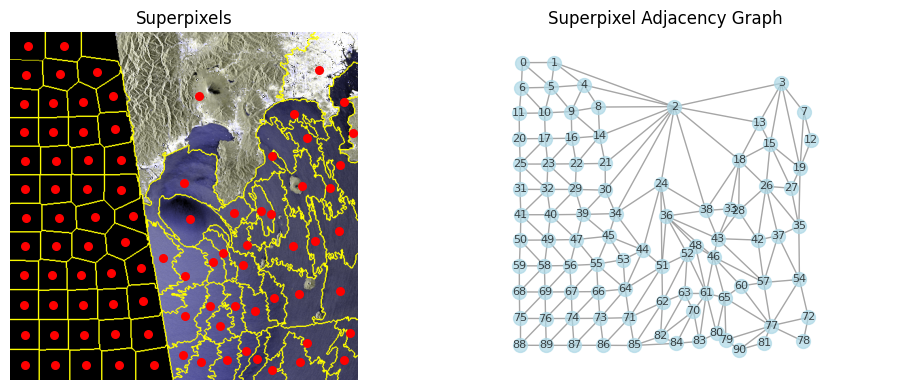

100%|██████████| 10000/10000 [00:12<00:00, 783.50it/s]


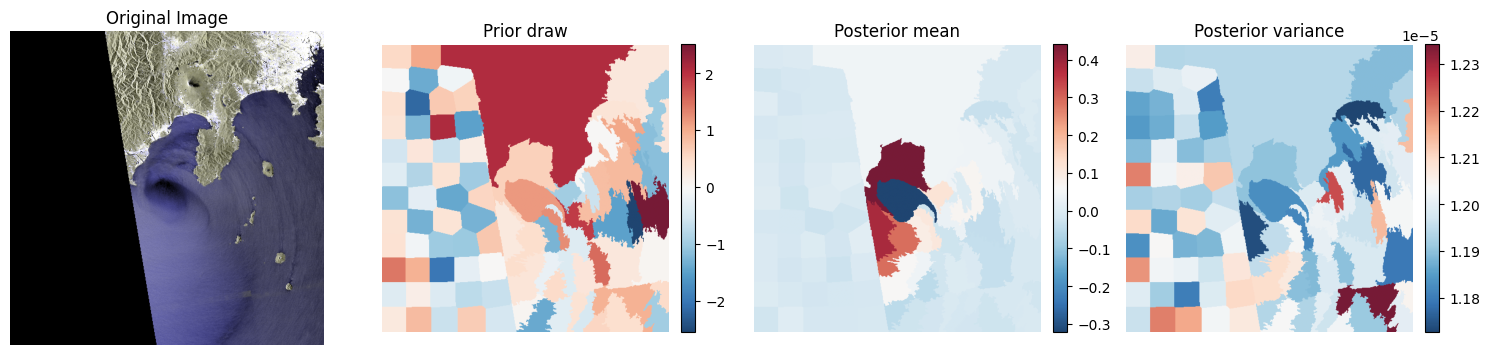

Model predictions: tensor([[0.0011, 0.9989]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
LIME image size: (512, 512, 3)


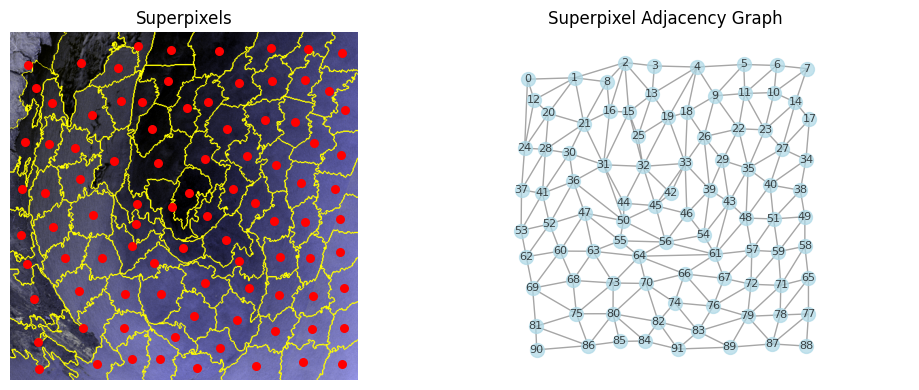

100%|██████████| 10000/10000 [00:12<00:00, 777.71it/s]


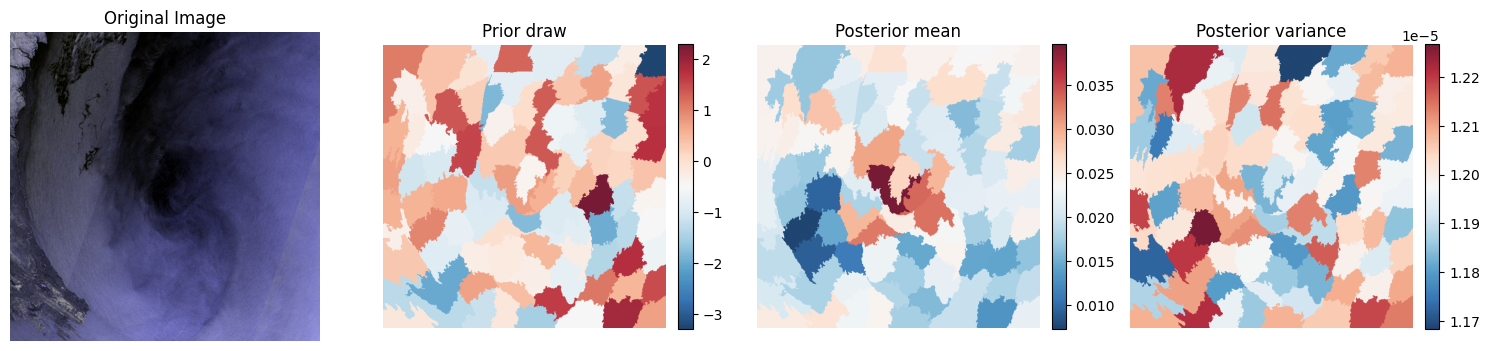

Model predictions: tensor([[0.0011, 0.9989]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [165]:
image_path = Path(test_dir)/'pos'/'cffe42_20191012T084028_20191012T084212_mos_rgb.png'
image = get_image(image_path)
transformed_image = test_transform(image)
n_samples = 10000  # set number of samples

# Convert tensor to format expected by LIME
lime_image_np = prepare_image_for_lime(transformed_image)
print(f"LIME image size: {lime_image_np.shape}")

explainer = BayesLIME(model, lime_image_np)
superpixels = explainer.custom_slic_segmentation(lime_image_np, n_superpixels=150, compactness=1)
centers = explainer.get_superpixel_centers(superpixels)
adjacency_matrix, degree_matrix = explainer.build_superpixel_graph(superpixels)
explainer.visualize_superpixel_graph(superpixels, centers, adjacency_matrix)

# Bayesian method - MGRF prior - uniform blurring
#prior_mean, prior_precision = explainer.build_prior(adjacency_matrix, degree_matrix, 'graph')
prior_mean_gauss, prior_precision_gauss = explainer.build_prior(adjacency_matrix, degree_matrix, 'gauss')

# Bayesian method - Gaussian prior - uniform blurring 
#prior_example = multivariate_normal.rvs(prior_mean, np.linalg.inv(prior_precision), size=1) # single draw from prior 
prior_example_gaussian = multivariate_normal.rvs(prior_mean_gauss, np.linalg.inv(prior_precision_gauss), size=1)

# model predictions - select method between 'blurred' and 'spatial'
y, interp_features, target_class = explainer.model_predictions_perturbations(lime_image_np, superpixels, 'blurred', n_samples)

# posterior updates MGRF
#posterior_mean, posterior_precision = explainer.build_MGRF_posterior(prior_precision, interp_features, y) 

# posterior updates gauss
posterior_mean_gauss, posterior_precision_gauss = explainer.build_MGRF_posterior(prior_precision_gauss, interp_features, y) 

# plotting
#posterior_example = multivariate_normal.rvs(posterior_mean, np.linalg.inv(posterior_precision), size=1)
#explainer.plot_superpixel_heatmap_prior_posterior(superpixels, prior_mean, prior_precision, posterior_mean, posterior_precision)
explainer.plot_superpixel_heatmap_prior_posterior(superpixels, prior_mean_gauss, prior_precision_gauss, posterior_mean_gauss, posterior_precision_gauss)

print(f'Model predictions: {torch.softmax(logits_sample_img, dim=1)}')


####################

image_path = Path(test_dir)/'pos'/'e8b0d4_20181231T025037_20181231T025219_mos_rgb.png'

image = get_image(image_path)
transformed_image = test_transform(image)
n_samples = 10000  # set number of samples

# Convert tensor to format expected by LIME
lime_image_np = prepare_image_for_lime(transformed_image)
print(f"LIME image size: {lime_image_np.shape}")

explainer = BayesLIME(model, lime_image_np)
superpixels = explainer.custom_slic_segmentation(lime_image_np, n_superpixels=100, compactness=7)
centers = explainer.get_superpixel_centers(superpixels)
adjacency_matrix, degree_matrix = explainer.build_superpixel_graph(superpixels)
explainer.visualize_superpixel_graph(superpixels, centers, adjacency_matrix)

# Bayesian method - MGRF prior - uniform blurring
#prior_mean, prior_precision = explainer.build_prior(adjacency_matrix, degree_matrix, 'graph')
prior_mean_gauss, prior_precision_gauss = explainer.build_prior(adjacency_matrix, degree_matrix, 'gauss')

# Bayesian method - Gaussian prior - uniform blurring 
#prior_example = multivariate_normal.rvs(prior_mean, np.linalg.inv(prior_precision), size=1) # single draw from prior 
prior_example_gaussian = multivariate_normal.rvs(prior_mean_gauss, np.linalg.inv(prior_precision_gauss), size=1)

# model predictions - select method between 'blurred' and 'spatial'
y, interp_features, target_class = explainer.model_predictions_perturbations(lime_image_np, superpixels, 'blurred', n_samples)

# posterior updates MGRF
#posterior_mean, posterior_precision = explainer.build_MGRF_posterior(prior_precision, interp_features, y) 

# posterior updates gauss
posterior_mean_gauss, posterior_precision_gauss = explainer.build_MGRF_posterior(prior_precision_gauss, interp_features, y) 

# plotting
#posterior_example = multivariate_normal.rvs(posterior_mean, np.linalg.inv(posterior_precision), size=1)
#explainer.plot_superpixel_heatmap_prior_posterior(superpixels, prior_mean, prior_precision, posterior_mean, posterior_precision)
explainer.plot_superpixel_heatmap_prior_posterior(superpixels, prior_mean_gauss, prior_precision_gauss, posterior_mean_gauss, posterior_precision_gauss)

print(f'Model predictions: {torch.softmax(logits_sample_img, dim=1)}')

Attempt to use different covariance for likelihood and different ways of approximating it, assuming dependence for example (estimate from data vs set additional prior on it vs fit sigma parameter under independence assumption)\\
Attempt to use binary features as well: sample binary vectors, create blacked out or mean substitution, run Bayesian approach on this - see how this compares to blurred model
Think about uncertainty for LIME in the case of CNN that are long to train (as in Kristoffer paper) \\


Preliminary conlclusions: high dependence on segmentation parameters (peril: injecting personal bias into what the model actually sees). 
prior has little influence as large number of samples pushes model towards data anyway 
variance is really small as more and more samples are gathered, hence not really any uncertainty quantification
main advantages of approach so far: no bandwidth parameter, stability. drawbacks: estimation of variance parameter necessary 

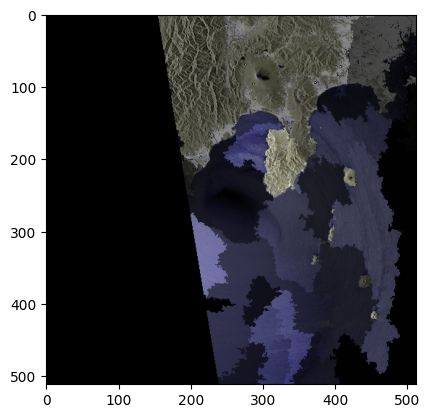

In [ ]:
plt.imshow(explainer.uniform_blurred_sampling(lime_image_np, superpixels, 1)[0][0])